# Visualize anatomical bounding box objects on CXR images

In [1]:
import pandas as pd
import numpy as np
import os, re 
from numpy import genfromtxt
import json
import cv2
import pydicom
import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
def readJSON(filepath):
    try:
        with open(filepath) as f:
            data = json.load(f)
            return data
    except Exception as e:
        print('File does not exist',filepath)
        return None

# Read relevant parts for the scene graph json    
# Rearrange so can look things up by object_id or bbox_name
def readSceneGraph(image_id, basepath):
    filepath = os.path.join(basepath,str(image_id.replace('.dcm','')) + '_SceneGraph.json')
    data = readJSON(filepath)  
    reason = data['reason_for_exam']
    objects = dict()
    objs = data['objects']
    for obj in objs:
        key = obj['object_id']
        objects[key] = obj
    attributes = dict()
    attrs = data['attributes']
    for attr in attrs:
        key = attr['bbox_name']
        if attr[key]:
            attributes[key] = attr
    relations = data['relationships']
    return reason, objects, attributes, relations


# load dicom image given path to images dir and dicom_id
def load_dicom(image_id, original_folder_images='/data/MIMIC/images/'):
    ds = pydicom.dcmread(os.path.join(original_folder_images, image_id)).pixel_array.astype(np.float)
    ds -= np.min(ds)
    ds /= np.max(ds)
    ds *= 255
    return ds


# Resize and pad image
def resize_pad(image, width, return_ratio = False):

    old_size = image.shape[:2]  # old_size is in (height, width) format

    ratio = float(width) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(image, (new_size[1], new_size[0]),interpolation=cv2.INTER_NEAREST)

    delta_w = width - new_size[1]
    delta_h = width - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)
    
    if return_ratio:
        return new_im, top, bottom, left, right, ratio
    else:
        return new_im

    
def checkCoord(x,dim):
    if x < 0:
        x = 0
    if x > dim:
        x = dim
    return x


# Draw bbox on image -- has the option to save image with not margin for annotation
def drawBbox(image, x1, y1, x2, y2, plot=True,exportfilepath=None):
    image = image.copy()
    stroke = 10
    w,h = image.shape
    x1 = checkCoord(int(x1), w)
    y1 = checkCoord(int(y1), h)
    x2 = checkCoord(int(x2), w)
    y2 = checkCoord(int(y2), h)
    image[y1:y1 + stroke, x1:x2] = 3
    image[y2:y2 + stroke, x1:x2] = 3
    image[y1:y2, x1:x1 + stroke] = 3
    image[y1:y2, x2:x2 + stroke] = 3
    
    if plot:
        dpi = 80
        # What size does the figure need to be in inches to fit the image?
        height, width = image.shape
        figsize = width / float(dpi), height / float(dpi)
        figsize = width / 500., height / 500.
        # To make a figure without the frame :
#         fig = plt.figure(frameon=False) # gives a bug in the plt 3.1.0 + this jupyter notebook env for some reason
        fig = plt.figure()
        fig.set_size_inches(figsize)
        # To make the content fill the whole figure
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        # Then draw your image on it :
        ax.imshow(image, cmap='gray', aspect='auto', interpolation='nearest')

        # Ensure we're displaying with square pixels and the right extent.
        # This is optional if you haven't called `plot` or anything else that might
        # change the limits/aspect.
        ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect='auto')
        
    if exportfilepath!=None:
        fig.savefig(exportfilepath, dpi=dpi, transparent=True)
        
#     if plot:
#         plt.figure(figsize=(10, 10))
#         plt.imshow(image, cmap='gray')
#         # plt.close() #or won't show up in notebook if run
#     if exportfilepath!=None:
#         fig.savefig(exportfilepath, dpi=80, transparent=True)
    return image


# visualize an object given image_id and name
def plot_object(image, objects, bbox_name, image_id, original):
    object_id = image_id.replace('.dcm','') + '_' + bbox_name
    if object_id in objects:
        box = objects[object_id]
        if original:
            x1 = box['original_x1']
            y1 = box['original_y1']
            x2 = box['original_x2']
            y2 = box['original_y2']
        else:
            x1 = box['x1']
            y1 = box['y1']
            x2 = box['x2']
            y2 = box['y2']
        image_plotted = drawBbox(image, x1, y1, x2, y2)
        return image_plotted
    else:
        print('Object ', bbox_name, ' not extracted for this image.')
        return image

In [ ]:
# TO DO: set paths for images_dir and graph_dir (scene graphs) to how things are set up on your local machine

# Here we flattened the nested directories from MIMIC-CXR to just one directory for all the dicoms.
images_dir = '/data/MIMIC/images/'

# Point to path where you unzipped the chest imagenome dataset
graph_dir = '../../../subset/scene_graph/' 

# specify the image you want to visualize
image_id = '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c.dcm'

In [9]:
# Read the original dicom
image = load_dicom(image_id, original_folder_images=images_dir)
print(image.shape)

(3056, 2544)


In [10]:
# Resize to 224x224
width = 224
img224 = resize_pad(image, width)
print(img224.shape)

(224, 224)


In [11]:
# Read the bounding box coordinates (objects) for different objects for this scene/CXR image
reason, objects, attributes, __ = readSceneGraph(image_id, graph_dir)

In [12]:
objects

{'76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right lung': {'object_id': '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right lung',
  'x1': 45,
  'y1': 32,
  'x2': 109,
  'y2': 142,
  'width': 64,
  'height': 110,
  'bbox_name': 'right lung',
  'synsets': ['C0225706'],
  'name': 'Right lung',
  'original_x1': 354,
  'original_y1': 436,
  'original_x2': 1227,
  'original_y2': 1937,
  'original_width': 873,
  'original_height': 1501},
 '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right upper lung zone': {'object_id': '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right upper lung zone',
  'x1': 54,
  'y1': 35,
  'x2': 109,
  'y2': 79,
  'width': 55,
  'height': 44,
  'bbox_name': 'right upper lung zone',
  'synsets': ['C0934570'],
  'name': 'Right upper lung zone',
  'original_x1': 477,
  'original_y1': 477,
  'original_x2': 1227,
  'original_y2': 1077,
  'original_width': 750,
  'original_height': 600},
 '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right mid lung zone': {'object_id': 

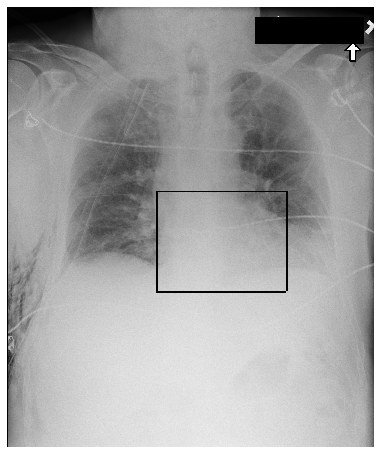

In [20]:
# Plot an object on the original image -- yes!! the left lung is on the right side in medical images -- it's mirrored
bbox_name = 'cardiac silhouette'
original = True

image2 = plot_object(image, objects, bbox_name, image_id, original)

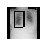

In [10]:
# Plot an object on the resized 224x224 image
bbox_name = 'right lung'
original = False

img224p = plot_object(img224, objects, bbox_name, image_id, original)

In [11]:
# The knowledge extracted from report about this anatomical location in the scene graph
attributes[bbox_name]

{'right lung': True,
 'bbox_name': 'right lung',
 'synsets': ['C0225706'],
 'name': 'Right lung',
 'attributes': [['tubesandlines|yes|chest tube'],
  ['anatomicalfinding|yes|increased reticular markings/ild pattern',
   'anatomicalfinding|yes|lung opacity',
   'disease|yes|interstitial lung disease',
   'nlp|yes|abnormal',
   'technicalassessment|yes|low lung volumes'],
  ['anatomicalfinding|no|pleural effusion',
   'anatomicalfinding|no|pneumothorax'],
  ['anatomicalfinding|no|pneumothorax', 'tubesandlines|yes|chest tube'],
  ['anatomicalfinding|no|pneumothorax'],
  ['tubesandlines|yes|chest tube']],
 'attributes_ids': [['C0008034'],
  ['C0240035', 'CL556823', 'C0206062', 'C0205161', 'C4049255'],
  ['CL545973;;C0032227', 'C1963215;;C0032326'],
  ['C1963215;;C0032326', 'C0008034'],
  ['C1963215;;C0032326'],
  ['C0008034']],
 'phrases': ['New right-sided chest tube ends at the apex.',
  'The\n lung volumes are low which explains increased interstitial markings in this\n patient with kno

In [12]:
# The attributes were extracted from reports 
# Their relation with the anatomical objects form the key clinical information in the CXR knowledge graph for that report
# There are some objects with no bounding boxes for the CXR image but still are in the CXr knowledge graph -- if described in report
# e.g.

attributes['right chest wall']

{'right chest wall': True,
 'bbox_name': 'right chest wall',
 'synsets': ['C0818149'],
 'name': 'Right lateral chest wall',
 'attributes': [['anatomicalfinding|yes|subcutaneous air',
   'nlp|yes|abnormal',
   'tubesandlines|yes|chest tube']],
 'attributes_ids': [['C0038536;;C3842127', 'C0205161', 'C0008034']],
 'phrases': ['Subcutaneous air adjacent to the chest tube is moderate.'],
 'phrase_IDs': ['58400371|7'],
 'sections': ['finalreport'],
 'comparison_cues': [[]],
 'temporal_cues': [[]],
 'severity_cues': [['severity|yes|moderate']],
 'texture_cues': [['texture|yes|lucency']],
 'object_id': '76289ac1-3ef7c087-3e77810d-63462e2c-20c0364c_right chest wall'}

# Visualize the anatomy-centered knowledge graph from CXR reports

The below CXR knowledge graph figure (shown in our corresponding paper) was plotted and saved in advance with neo4j. Here, we try to show that the graphs in Chest ImaGenome dataset are directed and there are different types of relations.

There are two main sources of relations in this graph:
1. From report description: affirmed (associated_with) vs negated (NOT_associated_with)
2. From CXR ontology: c2p (child-to-parent) vs p2c (parent-to-child)

In [3]:
#source: https://stackoverflow.com/questions/19470099/view-pdf-image-in-an-ipython-notebook
class PDF(object):
    def __init__(self, pdf, size=(200,200)):
        self.pdf = pdf
        self.size = size

    def _repr_html_(self):
        return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

    def _repr_latex_(self):
        return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('cxr_knowledge_graph_neo4j.pdf',size=(900,600))

In [4]:
# (Most of the) blue nodes are associated with bbox coordinates on the images, e.g.:
# here, right chest wall do not have bbox coordinates -- but can be approximately derived from the right lung (which we just haven't done yet)
# for radiological knowledge correctness, we wanted to associate attributes to not only the right coordinates on the image
# but also to the correct actual anatomy in UMLS 

PDF('chest_imaGenome_graph_sample_fig1.pdf',size=(900,600))

But in this notebook, we're using networkx to visualize the graph as it doesn't require set up of a separate graph engine on the local machine.

However, neo4j would be a more powerful graph engine for query and visualization, as shown in figure above.

In [14]:
# # Install library for graph visualization -- uncomment and run if not installed
# !pip install ipycytoscape

In [3]:
import json
import networkx as nx
import ipycytoscape
import ipywidgets as widgets

In [4]:
## Load enriched RDF graph 

## Use 'scenegraph_postprocessing.py' in the utils/postprocessing/ directory to generate this simpler json from the more detailed scene graph jsons

with open('../../../subset/scene_tabular/study_level_attribute_rdfgraphs.json','r') as f:
    data = json.load(f)

The cxr RDF knowledge graphs are rolled up to the report level -- not image level (dicom_id).

To get the study_id given the dicom_id, one can use MIMIC-CXR's cxr-record-list.csv, and vice versa.

In [5]:
# This is the mapping file -- note that only AP and PA view images are included in the Chest ImaGenome dataset
records = pd.read_csv('cxr-record-list_view.csv')
records = records[records.ViewPosition.isin(['PA','AP'])].reset_index(drop=True).copy()
print(records.shape)
records.head()

(243334, 5)


,subject_id,study_id,dicom_id,path,ViewPosition
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,PA
1,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,PA
2,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,AP
3,10000032,53911762,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,files/p10/p10000032/s53911762/fffabebf-74fd3a1...,AP
4,10000032,56699142,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,files/p10/p10000032/s56699142/ea030e7a-2e3b134...,AP


In [1]:
records[records.dicom_id == image_id.replace('.dcm','')].study_id

In [ ]:
## Choose one graph sample to visualize
study_id = '58400371'
sample = data[study_id].copy()

In [ ]:
# The RDF graph from the processing still misses the clinical history - reason for exam
# which can be read from the scene graph json
print(reason)

# Add the reason for exam relation to the graph
reason_rel = [[reason, 'history'],[study_id,'study_id'],'reason_for_exam']

sample.append(reason_rel)

In [ ]:
# The enriched RDF format for the nodes and edges

# # with this pattern:
# [
#        [ [node_id_1, node_type_1], [node_id_2, node_type_2], relation_name_A ],
#        [ [node_id_1, node_type_1], [node_id_3, node_type_3], relation_name_B ],
#        ...
# ]

# The UMLS CUI for each node is '|' concatenated with the node name. 
# If there are more than one suitable UMLS CUI, then they are joined by ;;

sample

## Visualize the graph sample - undirected

In [ ]:
## Generating graph from sample

class CustomNode(ipycytoscape.Node):
    def __init__(self, name, node_type=''):
        super().__init__()
        self.data['id'] = name
        self.classes = node_type

G = nx.DiGraph()
for edge in sample:
    node1 = edge[0]
    node2 = edge[1]
    n1 = CustomNode(node1[0].split('|')[0], node_type=node1[1])
    n2 = CustomNode(node2[0].split('|')[0], node_type=node2[1])
    G.add_node(n1)
    G.add_node(n2)
    G.add_edge(n1, n2, rel_type=edge[2])

In [ ]:
## Visualize the graph sample - undirected
vis_G = ipycytoscape.CytoscapeWidget()
vis_G.graph.add_graph_from_networkx(G)
vis_G.set_style([
                    {'selector': 'node','style': {
                        'font-family': 'helvetica',
                        'font-size': '12px',
                        'label': 'data(id)'
                        }
                    },
                    {
                        'selector': 'node.history',
                        'css': {
                            'background-color': 'pink'
                        }
                    },
                    {
                        'selector': 'node.location',
                        'css': {
                            'background-color': 'blue'
                        }
                    },
                    {
                        'selector': 'node.study_id',
                        'css': {
                            'background-color': 'black'
                        }
                    },
                    {
                        'selector': 'node.nlp_annotation',
                        'css': {
                            'background-color': 'red'
                        }
                    },
                    {
                        'selector': 'node.anatomicalfinding_annotation',
                        'css': {
                            'background-color': 'orange'
                        }
                    },
                    {
                        'selector': 'node.technicalassessment_annotation',
                        'css': {
                            'background-color': 'purple'
                        }
                    },
                    {
                        'selector': 'node.tubesandlines_annotation',
                        'css': {
                            'background-color': 'green'
                        }
                    },
                    {
                        'selector': 'node.device_annotation',
                        'css': {
                            'background-color': 'green'
                        }
                    },
                    {
                        'selector': 'node.disease_annotation',
                        'css': {
                            'background-color': 'yellow'
                        }
                    }])

In [ ]:
# Can drag and drop the nodes
# zoom in/out with scrolling, 
# and enlarge the panel by dragging down the right lower corner


# nodes and color coded with the categoryID (radiology semantic type) for the node
# the edges are undirected in this graph and no differentiation has been made between negated vs affirmed edges
    # the CXR study - black
    # reason for exam - pink
    # anatomical locations (objects in accompanying CXR images) - blue
    # anatomical finding attributes - orange
    # disease attributes - yellow
    # normal vs abnormal nlp attributes of anatomies - red
    # tubes and lines and devices attributes - green
    # technical assessment attributes - purple

vis_G

## Visualize the graph sample - directed

In [ ]:
## Generating graph from sample

G = nx.DiGraph()
for edge in sample:
    node1 = edge[0]
    node2 = edge[1]
    n1 = CustomNode(node1[0].split('|')[0], node_type=node1[1])
    n2 = CustomNode(node2[0].split('|')[0], node_type=node2[1])
    G.add_node(n1)
    G.add_node(n2)
    # negated
    if 'NOT' in edge[2]:
        value = 1
    # affirmed
    elif 'annotation' in edge[2]:
        value = 0
    # parent to child
    elif 'p2c' in edge[2]:
        value = 2
    # child to parent
    elif 'c2p' in edge[2]:
        value = 3
    # other
    else:
        value = 4
    G.add_edge(n1, n2, rel_type=edge[2], negated=value)


In [ ]:
## Visualize the graph sample - directed
vis_G_directed = ipycytoscape.CytoscapeWidget()
vis_G_directed.graph.add_graph_from_networkx(G)
vis_G_directed.set_layout(nodeSpacing=15, edgeLengthVal=15)
vis_G_directed.set_style([
                    {'selector': 'node','style': {
                        'font-family': 'helvetica',
                        'font-size': '12px',
                        'label': 'data(id)'
                        }
                    },
                    {
                        'selector': 'node.history',
                        'css': {
                            'background-color': 'pink'
                        }
                    },
                    {
                        'selector': 'node.location',
                        'css': {
                            'background-color': 'blue'
                        }
                    },
                    {
                        'selector': 'node.study_id',
                        'css': {
                            'background-color': 'black'
                        }
                    },
                    {
                        'selector': 'node.nlp_annotation',
                        'css': {
                            'background-color': 'red'
                        }
                    },
                    {
                        'selector': 'node.anatomicalfinding_annotation',
                        'css': {
                            'background-color': 'orange'
                        }
                    },
                    {
                        'selector': 'node.technicalassessment_annotation',
                        'css': {
                            'background-color': 'purple'
                        }
                    },
                    {
                        'selector': 'node.tubesandlines_annotation',
                        'css': {
                            'background-color': 'green'
                        }
                    },
                    {
                        'selector': 'node.device_annotation',
                        'css': {
                            'background-color': 'green'
                        }
                    },
                    {
                        'selector': 'node.disease_annotation',
                        'css': {
                            'width': 2,
                            'background-color': 'yellow'
                        }
                    },
                    {
                        "selector": "edge[negated=0]",
                        "style": {
                            'width': 2,
                            "line-color": "crimson"
                        }
                    },
                    {
                        "selector": "edge[negated=1]",
                        "style": {
                            'width': 2,
                            "line-color": "lightgreen"
                        }
                    },
                    {
                        'selector': 'edge',
                        'style': {
                            'width': 2,
                            'target-arrow-shape': 'triangle',
                            'curve-style': 'bezier'
                        }
                    }
                  ])

In [ ]:
# Edges are now directed and color coded for different relation types

# Affirmed edges are red
# Negated edges are light green
# other edges are bezier (light grey)

vis_G_directed